In [ ]:
## imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define time vector (e.g., from 0 to 10 seconds, with 1000 points)
time = np.linspace(0, 86400, 25_000)  # 100k points
frequency = 1 / 86400   # e.g., 3 full sine cycles per day  # Reasonable daily frequency
amplitude = 2.3547  # unitless (change this to adjust the wave amplitude)

# Generate sine wave values
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# Create DataFrame
sine_df_raw = pd.DataFrame({
    'Time (seconds)': time,
    'Sine Amplitude': sine_wave
})

# Total seconds in a day and week
SECONDS_PER_HOUR = 3600
SECONDS_PER_DAY = 86400
SECONDS_PER_WEEK = SECONDS_PER_DAY * 7

# Compute cyclical features
sine_df_raw['dow_cos'] = np.cos(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_WEEK) / SECONDS_PER_WEEK)
sine_df_raw['dow_sin'] = np.sin(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_WEEK) / SECONDS_PER_WEEK)
sine_df_raw['hour_cos'] = np.cos(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_DAY) / SECONDS_PER_DAY)

print(sine_df_raw)
sine_df = sine_df_raw.copy()

       Time (seconds)  Sine Amplitude   dow_cos   dow_sin  hour_cos
0            0.000000    0.000000e+00  1.000000  0.000000  1.000000
1            3.456138    5.918243e-04  1.000000  0.000036  1.000000
2            6.912276    1.183649e-03  1.000000  0.000072  1.000000
3           10.368415    1.775473e-03  1.000000  0.000108  1.000000
4           13.824553    2.367297e-03  1.000000  0.000144  0.999999
...               ...             ...       ...       ...       ...
24995    86386.175447   -2.367297e-03  0.623602  0.781742  0.999999
24996    86389.631585   -1.775473e-03  0.623574  0.781764  1.000000
24997    86393.087724   -1.183649e-03  0.623546  0.781787  1.000000
24998    86396.543862   -5.918243e-04  0.623518  0.781809  1.000000
24999    86400.000000   -5.767352e-16  0.623490  0.781831  1.000000

[25000 rows x 5 columns]


In [ ]:
## Before passing the data to the model, I need to drop time features
sine_df = sine_df.drop(columns=['Time (seconds)'])
sine_df = (sine_df - sine_df.mean()) / sine_df.std()

In [ ]:

# === Positional Encoding for continuous features ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super().__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

# === Transformer VAE with Dual-Head Decoder ===
class TransformerVAE(nn.Module):
    def __init__(self, feature_dim=4, d_model=64, latent_dim=16, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)

        self.latent_to_hidden = nn.Linear(latent_dim, d_model)

        # Separate decoder layers for reconstruction and forecasting
        decoder_layer_recon = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)
        decoder_layer_forecast = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)

        self.transformer_decoder_recon = nn.TransformerDecoder(decoder_layer_recon, num_layers=num_layers)
        self.transformer_decoder_forecast = nn.TransformerDecoder(decoder_layer_forecast, num_layers=num_layers)

        self.output_proj_recon = nn.Linear(d_model, feature_dim)
        self.output_proj_forecast = nn.Linear(d_model, feature_dim)


    def encode(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        encoded = self.transformer_encoder(x)
        pooled = encoded.mean(dim=0)
        mu = self.fc_mu(pooled)
        logvar = self.fc_logvar(pooled)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_reconstruct(self, z, seq_len, tgt_input):
        hidden = self.latent_to_hidden(z).unsqueeze(0)
        output = self.transformer_decoder_recon(tgt_input, memory=hidden)
        output = self.output_proj_recon(output.transpose(0, 1))
        return output

    def decode_forecast(self, z, forecast_len):
        hidden = self.latent_to_hidden(z).unsqueeze(0)
        tgt_input = torch.zeros(forecast_len, hidden.size(1), hidden.size(2), device=z.device)
        output = self.transformer_decoder_forecast(tgt_input, memory=hidden)
        output = self.output_proj_forecast(output.transpose(0, 1))
        return output

    def forward(self, x, forecast_len=1):
        seq_len = x.size(1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        x_input = self.input_proj(x)
        x_input = self.pos_encoder(x_input)
        x_input = x_input.transpose(0, 1)

        recon = self.decode_reconstruct(z, seq_len, tgt_input=x_input)
        forecast = self.decode_forecast(z, forecast_len)

        return recon, forecast, mu, logvar


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

forecast_steps = 1 # Number of steps to forecast
seq_len = 500  # Length of input sequence
num_features = 4

# Adjust total timesteps to accommodate forecast target
data_tensor = torch.tensor(sine_df.values, dtype=torch.float32)
print(data_tensor.shape)
total_timesteps = data_tensor.shape[0] - (data_tensor.shape[0] % (seq_len + forecast_steps))
print(total_timesteps)
data_tensor = data_tensor[:total_timesteps]

# Reshape with extended sequence length
sequences = data_tensor.view(-1, seq_len + forecast_steps, num_features)

# Split sequences into input and target
input_seq = sequences[:, :seq_len, :]         # [num_samples, seq_len, num_features]
future_target = sequences[:, seq_len:, :]     # [num_samples, forecast_steps, num_features]

# Train/Val split
split_idx = int(0.8 * len(sequences))
train_dataset = TensorDataset(input_seq[:split_idx], future_target[:split_idx])
val_dataset = TensorDataset(input_seq[split_idx:], future_target[split_idx:])

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


torch.Size([25000, 4])
24549
Train batches: 3, Val batches: 1


In [ ]:
vae = TransformerVAE(
    feature_dim=4,
    d_model=64,
    latent_dim=64,
    num_heads=4,
    num_layers=4, # this is what it was --> num_layers=4,
    dropout=0.3 # this is what it was --> dropout=0.1
)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
recon_loss_fn = nn.MSELoss()
forecast_loss_fn = nn.MSELoss()

results = []

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

for epoch in range(30):
    vae.train()
    epoch_loss, recon_loss_total, forecast_loss_total = 0, 0, 0

    for x, future_target in train_loader:

        recon, forecast, mu, logvar = vae(x, forecast_len=1)

        recon_loss = recon_loss_fn(recon, x)
        forecast_loss = forecast_loss_fn(forecast, future_target)
        loss = recon_loss + forecast_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        recon_loss_total += recon_loss.item()
        forecast_loss_total += forecast_loss.item()


    avg_loss = epoch_loss / len(train_loader)
    avg_recon = recon_loss_total / len(train_loader)
    avg_forecast = forecast_loss_total / len(train_loader)


    # 🔥 Validation Phase
    vae.eval()
    val_recon_total, val_forecast_total, val_kld_total = 0, 0, 0

    with torch.no_grad():
        for x_val, future_target_val in val_loader:
            recon_val, forecast_val, mu_val, logvar_val = vae(x_val, forecast_len=1)

            val_recon_loss = recon_loss_fn(recon_val, x_val)
            val_forecast_loss = forecast_loss_fn(forecast_val, future_target_val)
            val_kld = -0.5 * torch.mean(1 + logvar_val - mu_val.pow(2) - logvar_val.exp())

            val_recon_total += val_recon_loss.item()
            val_forecast_total += val_forecast_loss.item()
            val_kld_total += val_kld.item()

    avg_val_recon = val_recon_total / len(val_loader)
    avg_val_forecast = val_forecast_total / len(val_loader)
    avg_val_kld = val_kld_total / len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss {avg_loss:.4f} (Recon {avg_recon:.4f}, Forecast {avg_forecast:.4f} | Val (Recon {avg_val_recon:.4f}, Forecast {avg_val_forecast:.4f})")

    results.append({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "train_recon_loss": avg_recon,
        "train_forecast_loss": avg_forecast,
        "val_recon_loss": avg_val_recon,
        "val_forecast_loss": avg_val_forecast,
        "val_kld_loss": avg_val_kld
    })

# Save results
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("vae_dualdecoder_trainval.csv", index=False)
print("Results saved successfully")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Train batches: 3, Val batches: 1
Epoch 1: Train Loss 1.6930 (Recon 0.7502, Forecast 0.9428 | Val (Recon 2.0834, Forecast 2.8147)
Epoch 2: Train Loss 0.7759 (Recon 0.2567, Forecast 0.5192 | Val (Recon 1.1960, Forecast 2.0411)
Epoch 3: Train Loss 0.5186 (Recon 0.2503, Forecast 0.2683 | Val (Recon 0.9983, Forecast 1.4200)
Epoch 4: Train Loss 0.3934 (Recon 0.1551, Forecast 0.2383 | Val (Recon 0.8068, Forecast 1.0286)
Epoch 5: Train Loss 0.2942 (Recon 0.1279, Forecast 0.1663 | Val (Recon 0.8237, Forecast 0.8790)
Epoch 6: Train Loss 0.2728 (Recon 0.1155, Forecast 0.1573 | Val (Recon 0.7441, Forecast 0.8248)
Epoch 7: Train Loss 0.2035 (Recon 0.0990, Forecast 0.1045 | Val (Recon 0.6740, Forecast 0.7329)
Epoch 8: Train Loss 0.2110 (Recon 0.0947, Forecast 0.1163 | Val (Recon 0.6995, Forecast 0.9017)
Epoch 9: Train Loss 0.2163 (Recon 0.0902, Forecast 0.1261 | Val (Recon 0.5709, Forecast 1.0940)
Epoch 10: Train Loss 0.2117 (Recon 0.0834, Forecast 0.1282 | Val (Recon 0.5017, Forecast 0.7933)
Epoch 

In [ ]:
def recursive_forecast_amplitude(model, x_init, steps=30, amplitude_idx=0):
    """
    Predict multiple future steps recursively using model's forecast head.

    Args:
        model: trained TransformerVAE model
        x_init: [batch_size, seq_len, feature_dim] - starting sequence
        steps: int - future steps to predict
        amplitude_idx: int - index of amplitude feature to extract

    Returns:
        preds: [batch_size, steps] - predicted amplitude values
    """

    model.eval()
    preds = []
    x_curr = x_init.clone().detach()

    with torch.no_grad():
        for _ in range(steps):
            recon, future_pred, _, _ = model(x_curr, forecast_len=1)  # Predict 1 step
            next_feat = future_pred[:, -1, :]  # Next predicted feature vector
            next_amp = next_feat[:, amplitude_idx]

            preds.append(next_amp.unsqueeze(1))
            x_curr = torch.cat([x_curr[:, 1:, :], next_feat.unsqueeze(1)], dim=1)

    preds = torch.cat(preds, dim=1)
    return preds

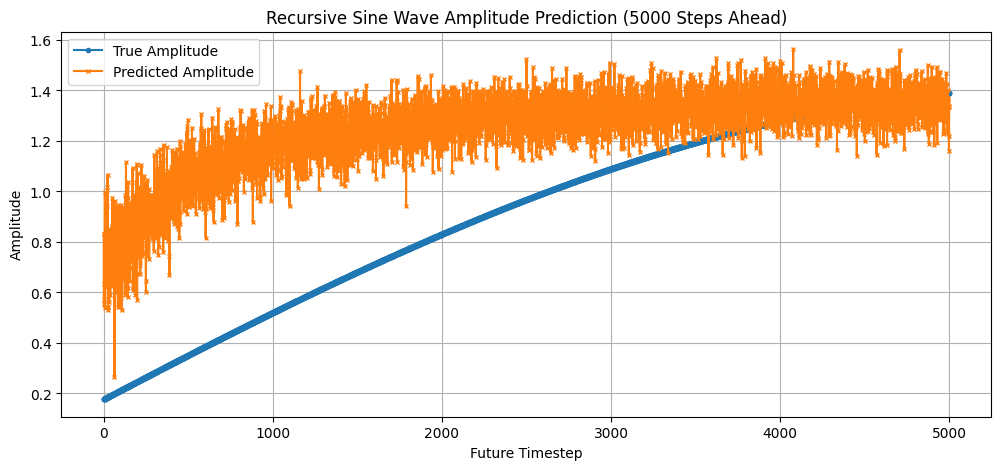

In [ ]:
import matplotlib.pyplot as plt

all = 5000

amplitude_idx = sine_df.columns.get_loc('Sine Amplitude')

# Example sequence for context
example_seq = sequences[0].unsqueeze(0)  # [1, seq_len, feature_dim]

# True future amplitude for comparison
true_amplitude = data_tensor[seq_len : seq_len + all, amplitude_idx]

# Predict recursively
predicted_amplitude = recursive_forecast_amplitude(vae, example_seq, steps=all, amplitude_idx=amplitude_idx)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(all), true_amplitude.cpu(), label='True Amplitude', marker='o', markersize=3)
plt.plot(range(all), predicted_amplitude.squeeze(0).cpu(), label='Predicted Amplitude', marker='x', markersize=3)
plt.title(f"Recursive Sine Wave Amplitude Prediction ({all} Steps Ahead)")
plt.xlabel("Future Timestep")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()